In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'C:/Users/s_csmscox/jupyterSave/eye_blink/train'
validation_dir = 'C:/Users/s_csmscox/jupyterSave/eye_blink/valid'

batch_size = 50
img_size = 64

train_datagen = ImageDataGenerator(rescale=1/255)

# train_datagen = ImageDataGenerator(rescale=1/255,
#                                    rotation_range=20,  # 지정된 각도 범위내에서 임의로 원본 이미지를 회전
#                                    width_shift_range=0.1,
#                                    height_shift_range=0.1,
#                                    zoom_range=0.1,    #  1-수치 혹은 1+수치만큼 확대 및 축소
#                                    horizontal_flip=True,
#                                    vertical_flip=True)



validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size,img_size),                      
    batch_size=batch_size,     
    class_mode='categorical'                    
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_size,img_size),                       
    batch_size=batch_size,    
    class_mode='categorical'                    
)

Found 54332 images belonging to 2 classes.
Found 13585 images belonging to 2 classes.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.applications import VGG16

np.random.seed(42)

# 모델 구축

# vgg16 모델 불러오기
pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
pre_trained_vgg.trainable = False
pre_trained_vgg.summary()

# vgg16 모델에 덧붙이기
model = Sequential()
model.add(pre_trained_vgg)
model.add(Flatten())
model.add(Dense(4096, activation='relu', kernel_initializer='he_normal'))
#model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu', kernel_initializer='he_normal'))
#model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))

model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',
                metrics=['accuracy'])

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [6]:
early_stopping = EarlyStopping(patience = 5) # 조기종료 콜백함수 정의

# 데이터 개수 / batch_size
steps_per_epoch = 54332 / batch_size
val_steps = 13585 / batch_size

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    callbacks=[early_stopping],
                    verbose=1
                    )

Epoch 1/100
1087/1086 [==============================] - 218s 201ms/step - loss: 0.2857 - accuracy: 0.8871 - val_loss: 0.1829 - val_accuracy: 0.9382
Epoch 2/100
1087/1086 [==============================] - 22s 20ms/step - loss: 0.1643 - accuracy: 0.9410 - val_loss: 0.1371 - val_accuracy: 0.9522
Epoch 3/100
1087/1086 [==============================] - 22s 20ms/step - loss: 0.1340 - accuracy: 0.9519 - val_loss: 0.1361 - val_accuracy: 0.9480
Epoch 4/100
1087/1086 [==============================] - 22s 20ms/step - loss: 0.1185 - accuracy: 0.9572 - val_loss: 0.1070 - val_accuracy: 0.9619
Epoch 5/100
1087/1086 [==============================] - 22s 20ms/step - loss: 0.1047 - accuracy: 0.9623 - val_loss: 0.1020 - val_accuracy: 0.9658
Epoch 6/100
1087/1086 [==============================] - 22s 20ms/step - loss: 0.0982 - accuracy: 0.9654 - val_loss: 0.0957 - val_accuracy: 0.9654
Epoch 7/100
1087/1086 [==============================] - 23s 21ms/step - loss: 0.0913 - accuracy: 0.9669 - val_loss:

In [7]:
#### Fine Tuning

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

np.random.seed(42)

img_size = 64

early_stopping = EarlyStopping(patience = 5) # 조기종료 콜백함수 정의

# 데이터 개수 / batch_size
steps_per_epoch = 54332 / batch_size
val_steps = 13585 / batch_size

# InceptionResNetV2 모델 불러오기
pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
pre_trained_vgg.trainable = False

set_trainable = False
for layer in pre_trained_vgg.layers:
    if layer.name == 'block4_conv1 ':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# 일반적으로 learning_rate를 더 작게 설정
model.compile(optimizer=Adam(learning_rate=1e-7), loss='categorical_crossentropy',
                metrics=['accuracy'])

In [8]:
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    callbacks=[early_stopping],
                    verbose=1
                    )

Epoch 1/100
1087/1086 [==============================] - 28s 25ms/step - loss: 0.0363 - accuracy: 0.9870 - val_loss: 0.0627 - val_accuracy: 0.9782
Epoch 2/100
1087/1086 [==============================] - 22s 20ms/step - loss: 0.0344 - accuracy: 0.9879 - val_loss: 0.0619 - val_accuracy: 0.9789
Epoch 3/100
1087/1086 [==============================] - 22s 20ms/step - loss: 0.0337 - accuracy: 0.9883 - val_loss: 0.0615 - val_accuracy: 0.9789
Epoch 4/100
1087/1086 [==============================] - 23s 21ms/step - loss: 0.0333 - accuracy: 0.9884 - val_loss: 0.0614 - val_accuracy: 0.9789
Epoch 5/100
1087/1086 [==============================] - 22s 20ms/step - loss: 0.0330 - accuracy: 0.9885 - val_loss: 0.0612 - val_accuracy: 0.9792
Epoch 6/100
1087/1086 [==============================] - 22s 20ms/step - loss: 0.0328 - accuracy: 0.9887 - val_loss: 0.0610 - val_accuracy: 0.9792
Epoch 7/100
1087/1086 [==============================] - 22s 20ms/step - loss: 0.0326 - accuracy: 0.9887 - val_loss: 0

In [9]:
model.save('C:/Users/s_csmscox/jupyterSave/eye_blink/eye_blink_vgg16.h5')

In [4]:
from tensorflow.keras.models import load_model

model = load_model('C:/Users/s_csmscox/jupyterSave/eye_blink/eye_blink_vgg16.h5')

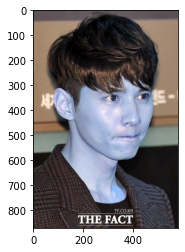

In [38]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

face_cascade = cv2.CascadeClassifier('C:/Users/s_csmscox/anaconda3/Lib/site-packages/cv2/data/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('C:/Users/s_csmscox/anaconda3/Lib/site-packages/cv2/data/haarcascade_eye.xml')
img = cv2.imread('./face2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img)
plt.show()

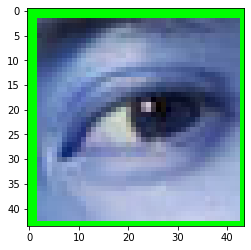

In [40]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        img_trim = img[y+ey:y+ey+eh, x+ex:x+ex+ew]
        
        
plt.imshow(img_trim)
plt.show()

In [21]:
img_size =64


img_trim = np.asarray(img_trim)
img_trim = img_trim.reshape(img_size,img_size,3)

plt.imshow(img_trim)
plt.show()

img_trim = img_trim/255

img_trim = img_trim.reshape(1,128,128,3)
pred = model.predict(img_trim)

for i in pred:
    m = i.max()
    for j in range(2):
        if i[j] == m:
            if j == 0:
                print("예측 : 안졸음")
            else:
                print("예측 : 졸음")


ValueError: cannot reshape array of size 9075 into shape (64,64,3)